```
From: https://github.com/ksatola
Version: 0.0.1

TODOs
1. 

```

# Unsupervised Feature Selection Methods

- Removing features with low variance
- Removing collinear columns (avoiding multicollinear features)

In [1]:
# Connect with underlying Python code
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

In [2]:
from datasets import (
    get_dataset
)

from feature_selection import (
    select_features
)

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [4]:
# target = 'survived'
df = get_dataset('titanic3')
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


---

## Removing features with low variance
[VarianceThreshold](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection) is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples.

As an example, suppose that we have a dataset with boolean features, and we want to remove all features that are either one or zero (on or off) in more than 80% of the samples. Boolean features are `Bernoulli random variables`, and the variance of such variables is given by 
```
Var[X]=p(1-p)
```
so we can select using the threshold .8 * (1 - .8):

In [5]:
from sklearn.feature_selection import VarianceThreshold
X = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)

array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

We can also count number of value counts groups to recognize how many different values represent a feature.

---

## Removing collinear columns 1/2

In [6]:
corr = df.corr()
corr

,pclass,survived,age,sibsp,parch,fare,body
pclass,1.000000,-0.312469,-0.408106,0.060832,0.018322,-0.558629,-0.034642
survived,-0.312469,1.000000,-0.055513,-0.027825,0.082660,0.244265,NaN
age,-0.408106,-0.055513,1.000000,-0.243699,-0.150917,0.178739,0.058809
sibsp,0.060832,-0.027825,-0.243699,1.000000,0.373587,0.160238,-0.099961
parch,0.018322,0.082660,-0.150917,0.373587,1.000000,0.221539,0.051099
fare,-0.558629,0.244265,0.178739,0.160238,0.221539,1.000000,-0.043110
body,-0.034642,NaN,0.058809,-0.099961,0.051099,-0.043110,1.000000


In [7]:
mask = np.triu(df.corr(), k=1)
mask

array([[ 0.        , -0.31246936, -0.40810574,  0.06083201,  0.0183222 ,
        -0.55862873, -0.03464194],
       [ 0.        ,  0.        , -0.05551252, -0.02782512,  0.08265957,
         0.24426547,         nan],
       [ 0.        ,  0.        ,  0.        , -0.24369949, -0.15091743,
         0.17873932,  0.05880873],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.37358719,
         0.16023826, -0.09996053],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.22153866,  0.05109925],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.04311018],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]])

In [8]:
mask = np.triu(df.corr(), k=1).astype(bool)
mask

array([[False,  True,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True],
       [False, False, False, False,  True,  True,  True],
       [False, False, False, False, False,  True,  True],
       [False, False, False, False, False, False,  True],
       [False, False, False, False, False, False, False]])

In [9]:
corr_no_diag = corr.where(mask)
corr_no_diag

,pclass,survived,age,sibsp,parch,fare,body
pclass,NaN,-0.312469,-0.408106,0.060832,0.018322,-0.558629,-0.034642
survived,NaN,NaN,-0.055513,-0.027825,0.082660,0.244265,NaN
age,NaN,NaN,NaN,-0.243699,-0.150917,0.178739,0.058809
sibsp,NaN,NaN,NaN,NaN,0.373587,0.160238,-0.099961
parch,NaN,NaN,NaN,NaN,NaN,0.221539,0.051099
fare,NaN,NaN,NaN,NaN,NaN,NaN,-0.043110
body,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# A different way
corr = df.corr()
mask = np.triu(np.ones(corr.shape), k=1).astype(bool)
corr_no_diag = corr.where(mask)
corr_no_diag

,pclass,survived,age,sibsp,parch,fare,body
pclass,NaN,-0.312469,-0.408106,0.060832,0.018322,-0.558629,-0.034642
survived,NaN,NaN,-0.055513,-0.027825,0.082660,0.244265,NaN
age,NaN,NaN,NaN,-0.243699,-0.150917,0.178739,0.058809
sibsp,NaN,NaN,NaN,NaN,0.373587,0.160238,-0.099961
parch,NaN,NaN,NaN,NaN,NaN,0.221539,0.051099
fare,NaN,NaN,NaN,NaN,NaN,NaN,-0.043110
body,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
limit = 0.95 # find columns that have a correlation coefficient of .95 or above

colls = [c for c in corr_no_diag.columns if any(abs(corr_no_diag[c]) > limit)]
colls

[]

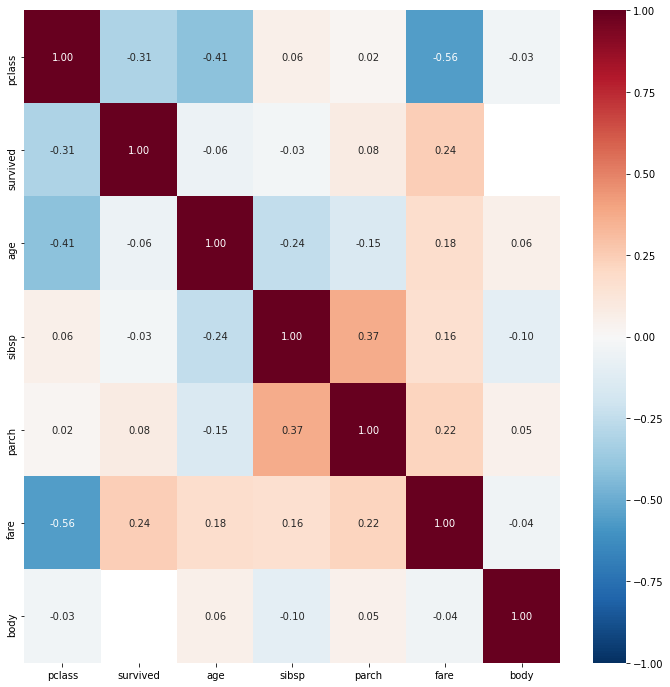

In [12]:
from seaborn import heatmap

fig, ax = plt.subplots(figsize=(12, 12))
ax = heatmap(df.corr(), fmt=".2f", annot=True, ax=ax, cmap="RdBu_r", vmin=-1, vmax=1,)
fig.savefig("images/feature_selection_correlation1.png", dpi=300)

The `rfpimp` package has a visualization of `multicollinearity`. The `plot_dependence_heatmap` function trains a random forest for each numeric column from the other columns in a training dataset. The dependence value is the R2 score from the out-of-bag (OOB) estimates for predicting that column.

The suggested way to use this plot is to find values close to 1. The label on the X axis is the feature that predicts the Y axis label. If a feature predicts another, you can remove the predicted feature (the feature on the Y axis). In our example, fare predicts pclass, sibsp, parch, and embarked_Q. We should be able to keep fare and remove the others and get similar performance.

In [13]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_num = df.select_dtypes(include=numerics)
df_num = df_num.drop(columns=['body'])
df_num.dropna(inplace=True)

y = df_num[['survived']]
X = df_num.drop(columns=['survived'])

X.head()

,pclass,age,sibsp,parch,fare
0,1,29.0000,0,0,211.3375
1,1,0.9167,1,2,151.5500
2,1,2.0000,1,2,151.5500
3,1,30.0000,1,2,151.5500
4,1,25.0000,1,2,151.5500


In [14]:
X.shape

(1045, 5)

In [15]:
from sklearn.model_selection import train_test_split

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [16]:
from sklearn.ensemble import RandomForestClassifier

# Here is code showing that we get a similar score if we remove these columns
cols_to_remove = [
    "sibsp",
    "parch",
]

rf3 = RandomForestClassifier(random_state=42)
rf3.fit(X_train[[c for c in X_train.columns if c not in cols_to_remove]], y_train.values.ravel(),)
print(f'Accuracy of the dataset with removed columns: {rf3.score(X_test[[c for c in X_train.columns if c not in cols_to_remove]], y_test,):.3f}%')

rf4 = RandomForestClassifier(random_state=42)
rf4.fit(X_train, y_train.values.ravel())
print(f'Accuracy of the dataset with all columns: {rf4.score(X_test, y_test):.3f}%')

Accuracy of the dataset with removed columns: 0.634%
Accuracy of the dataset with all columns: 0.637%


---

## Handling Multicollinear Features 2/2
When features are collinear, permutating one feature will have little effect on the models performance because it can get the same information from a correlated feature. One way to handle multicollinear features is by performing `hierarchical clustering` on the `Spearman rank-order correlations`, picking a threshold, and keeping a single feature from each cluster ([see sklearn documentation](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py)).

In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

### The Problem - Random Forest Feature Importance on Breast Cancer Data
In the example below we show that the accuracy will stay the same when we remove collinear features.

First, we train a random forest on the breast cancer dataset and evaluate its accuracy on a test set:

In [4]:
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))

Accuracy on test data: 0.97


<ipython-input-6-c9680ff07714>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])


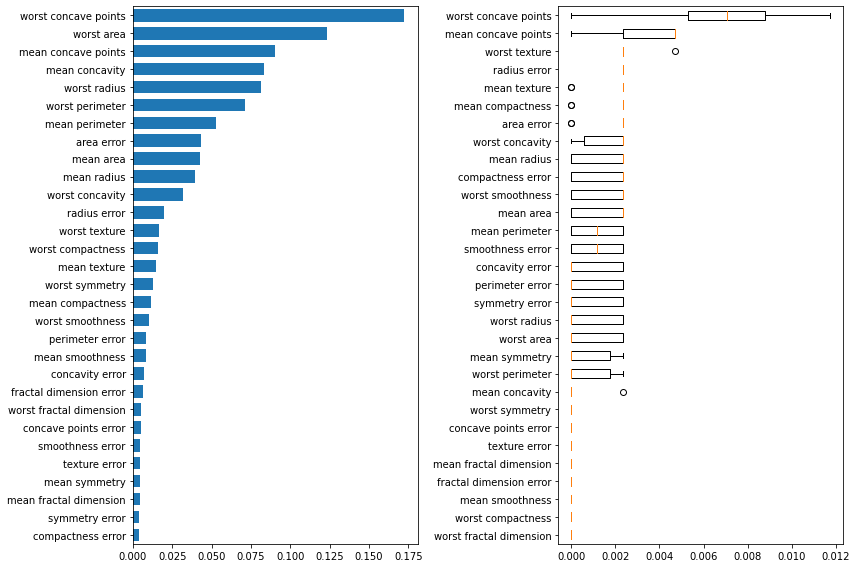

In [6]:
result = permutation_importance(clf, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False, labels=data.feature_names[perm_sorted_idx])
fig.tight_layout()
plt.show()

Next, we plot the tree based feature importance and the permutation importance. The permutation importance plot shows that permuting a feature drops the accuracy by at most 0.012, which would suggest that none of the features are important. This is in contradiction with the high test accuracy computed above: some feature must be important. The permutation importance is calculated on the training set to show how much the model relies on each feature during training.

### Solution - Handling Multicollinear Features
When features are collinear, permutating one feature will have little effect on the models performance because it can get the same information from a correlated feature. One way to handle multicollinear features is by performing `hierarchical clustering` on the `Spearman rank-order correlations`, picking a threshold, and keeping a single feature from each cluster. First, we plot a heatmap of the correlated features.

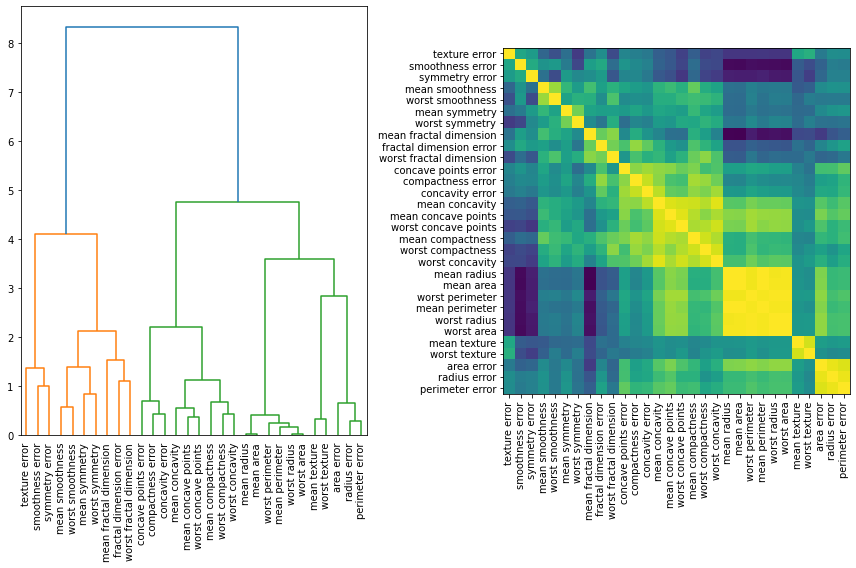

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=data.feature_names.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

Next, we manually pick a threshold by visual inspection of the dendrogram to group our features into clusters and choose a feature from each cluster to keep, select those features from our dataset, and train a new random forest. The test accuracy of the new random forest did not change much compared to the random forest trained on the complete dataset.

In [9]:
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)

for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
    
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)

print("Accuracy on test data with features removed: {:.2f}".format(clf_sel.score(X_test_sel, y_test)))

Accuracy on test data with features removed: 0.97


### The impurity-based feature importance can inflate the importance of numerical features
We will [compare the impurity-based feature importance of RandomForestClassifier with the permutation importance on the titanic dataset using permutation_importance](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py). We will show that **the impurity-based feature importance can inflate the importance of numerical features**.

Furthermore, **the impurity-based feature importance of random forests suffers from being computed on statistics derived from the training dataset**: the importances can be high even for features that are not predictive of the target variable, as long as the model has the capacity to use them to overfit.

This example shows how to **use Permutation Importances as an alternative** that can mitigate those limitations.

In [11]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

#### Data Loading and Feature Engineering
Let’s use pandas to load a copy of the titanic dataset. The following shows how to apply separate preprocessing on numerical and categorical features.

We further include two random variables that are not correlated in any way with the target variable (survived):
- random_num is a high cardinality numerical variable (as many unique values as records),
- random_cat is a low cardinality categorical variable (3 possible values).

In [12]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
rng = np.random.RandomState(seed=42)
X['random_cat'] = rng.randint(3, size=X.shape[0])
X['random_num'] = rng.randn(X.shape[0])

In [14]:
X.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,random_cat,random_num
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",2,-1.110576
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",0,1.752270
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",2,0.935678
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON",2,1.271555
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",0,0.721672


In [15]:
categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']

X = X[categorical_columns + numerical_columns]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
])

In [17]:
X.head()

,pclass,sex,embarked,random_cat,age,sibsp,parch,fare,random_num
0,1.0,female,S,2,29.0000,0.0,0.0,211.3375,-1.110576
1,1.0,male,S,0,0.9167,1.0,2.0,151.5500,1.752270
2,1.0,female,S,2,2.0000,1.0,2.0,151.5500,0.935678
3,1.0,male,S,2,30.0000,1.0,2.0,151.5500,1.271555
4,1.0,female,S,0,25.0000,1.0,2.0,151.5500,0.721672


In [18]:
preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['pclass', 'sex', 'embarked',
                                                   'random_cat']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['age', 'sibsp', 'par

#### Accuracy
**Prior to inspecting the feature importances, it is important to check that the model predictive performance is high enough**. Indeed there would be little interest of inspecting the important features of a non-predictive model.

Here one can observe that the train accuracy is very high (the forest model has enough capacity to completely memorize the training set) but it can still generalize well enough to the test set thanks to the built-in bagging of random forests.

It might be possible to trade some accuracy on the training set for a slightly better accuracy on the test set by limiting the capacity of the trees (for instance by setting `min_samples_leaf=5` or `min_samples_leaf=1`0) so as to limit overfitting while not introducing too much underfitting.

However let’s keep our high capacity random forest model for now so as to illustrate some pitfalls with feature importance on variables with many unique values.

In [19]:
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF train accuracy: 1.000
RF test accuracy: 0.817


#### Tree’s Feature Importance from Mean Decrease in Impurity (MDI)
The `impurity-based feature importance` ranks the numerical features to be the most important features. As a result, the non-predictive `random_num` variable is ranked the most important! This problem stems from two limitations of impurity-based feature importances:
- impurity-based importances are biased towards high cardinality features;
- impurity-based importances are computed on training set statistics and therefore do not reflect the ability of feature to be useful to make predictions that generalize to the test set (when the model has enough capacity).

<ipython-input-21-9abc2ade3fed>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


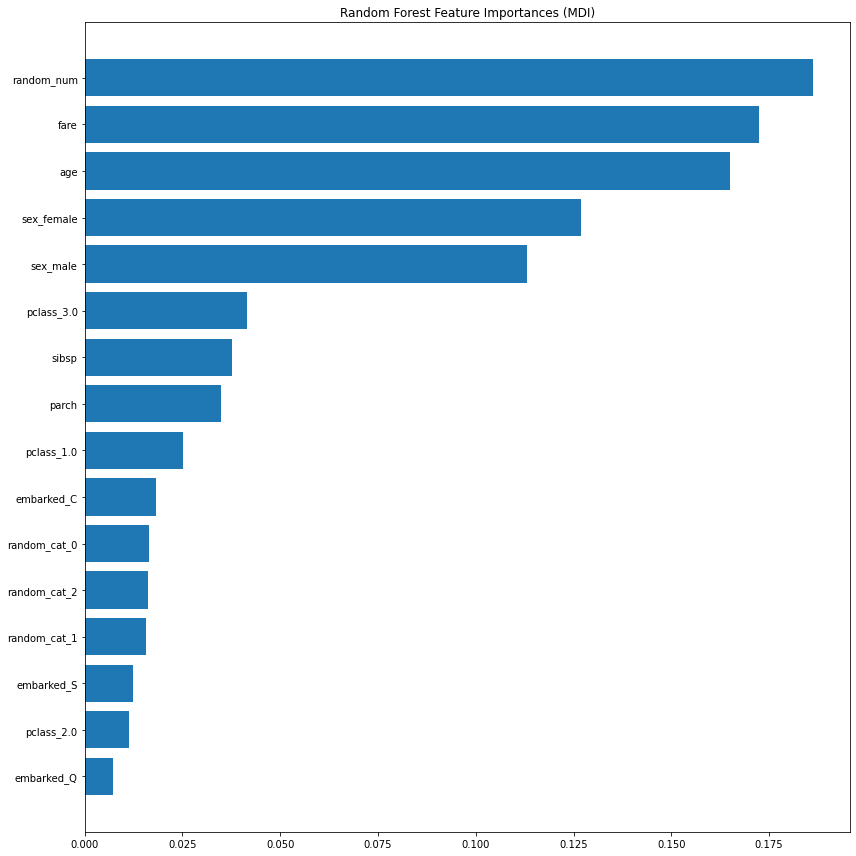

In [21]:
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(12, 12))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

**As an alternative, the `permutation importance` of rf are computed on a `held out test set`**. This shows that the low cardinality categorical feature, sex is the most important feature. Also note that both random features have very low importances (close to 0) as expected.

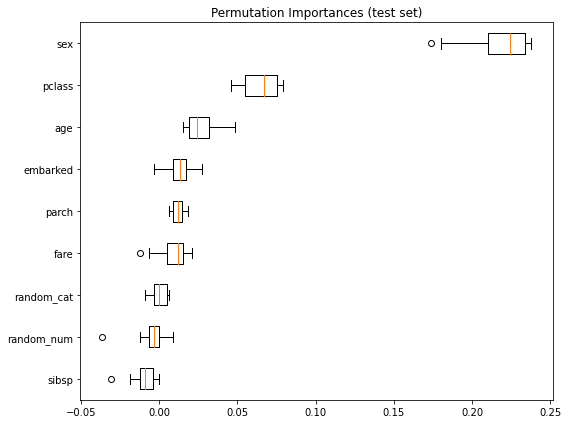

In [24]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

It is also possible to compute the permutation importances on the training set. This reveals that `random_num` gets a significantly higher importance ranking than when computed on the test set. The difference between those two plots is a confirmation that the RF model has enough capacity to use that random numerical feature to overfit. You can further confirm this by re-running this example with constrained RF with `min_samples_leaf=10`.

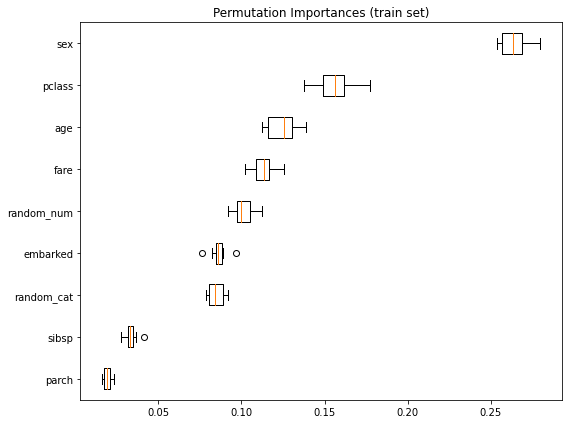

In [25]:
result = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()